# Facial Expression Recognition
## Koushik


# Import Libraires
## using pytorch framework to build our network and downloading data from kaggle library

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import math
import torch.nn.functional as F
!pip install opencv-python
import cv2

In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

## Download api token for kaggle under my account settings in kaggle profile. Upload it in the bottom cell so we can download data


In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge
!unzip /content/facial-expression-recognitionferchallenge.zip

 84% 81.0M/96.6M [00:01<00:00, 52.3MB/s]
100% 96.6M/96.6M [00:01<00:00, 79.9MB/s]
Archive:  /content/facial-expression-recognitionferchallenge.zip
  inflating: Submission.csv          
  inflating: fer2013/fer2013/README  
  inflating: fer2013/fer2013/fer2013.bib  
  inflating: fer2013/fer2013/fer2013.csv  


# Read Data 

In [ ]:
data_path = "/content/fer2013/fer2013/fer2013.csv" # Path to dataset
data = pd.read_csv(data_path,delimiter=",")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data['Usage'].unique() # Labels of the dataset

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
data.shape # Number of Images vs type of Images(Train/Test)

(35887, 3)

In [ ]:
train = data[data['Usage']=='Training']
public_test = data[data['Usage'] == 'PublicTest']
public_test.reset_index(drop=True,inplace=True)
private_test = data[data['Usage'] == 'PrivateTest']
private_test.reset_index(drop=True,inplace=True)
print(train.shape,public_test.shape,private_test.shape)# See How many images are in Train,Test

(28709, 3) (3589, 3) (3589, 3)


In [ ]:
public_test.head()

,emotion,pixels,Usage
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
1,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
2,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
3,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
4,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [ ]:
def pixels_labels(df):
  pixels = df['pixels'].str.split(expand=True)
  img_size = int(np.sqrt(pixels.shape[1]))
  pixels_arr = np.array(pixels).reshape(-1,img_size,img_size).astype(int)
  return pixels_arr,df['emotion']


In [ ]:
pixels_train,labels_train=pixels_labels(train)
pixels_public,labels_public=pixels_labels(public_test)
pixels_private,labels_private=pixels_labels(private_test)
labels = data['emotion']
pixels = data['pixels']
usage = data['Usage']
pixels = pixels.str.split(expand=True)
img_size = int(np.sqrt(pixels.shape[1]))
pixels_arr = np.array(pixels).reshape(-1,img_size,img_size).astype(int)
print("pixels_arr shape " + str(pixels_arr.shape))

pixels_arr shape (35887, 48, 48)


## Sample Few Images

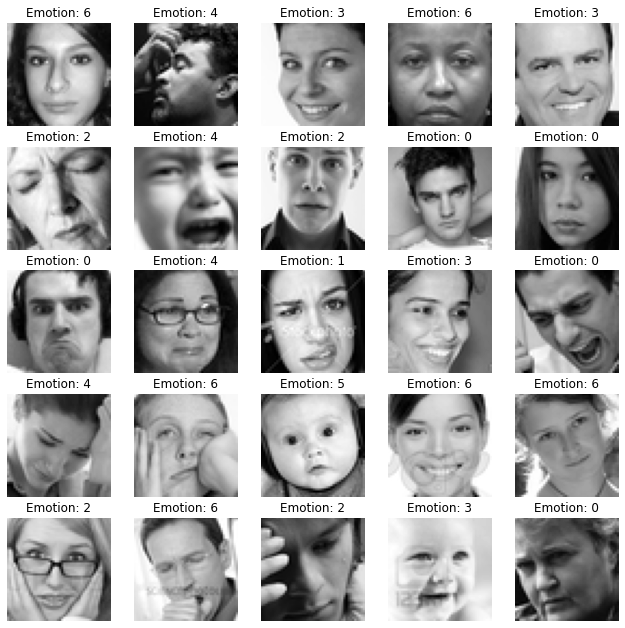

In [ ]:
grid_size=5
fig_size =(grid_size*2+1,grid_size*2+1)
indices = random.sample(range(0,pixels_arr.shape[0]-1),grid_size**2)
plt.figure(figsize = fig_size)
for i, idx in enumerate(indices):
  plt.subplot(grid_size,grid_size,i+1)
  img = pixels_arr[idx]
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title('Emotion: {}'.format(labels[idx]))
plt.show()

# Create Dataloader

In [ ]:
class fer(Dataset):
  def __init__(self, pixels_arr, labels,transform=None):
    self.x = pixels_arr
    self.y = labels
    self.n_samples = len(self.x)
    self.transform = transform

  def __getitem__(self, index):
    sample = self.x[index],np.array(self.y[index])
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.n_samples
  

class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

class NormalizingImage: ## Normalize the image by dividing with max intensity
  def __call__(self, sample):
    inputs, targets = sample
    inputs = inputs/255
    return inputs, targets

class Label_converter:
  def __call__(self, sample):
    inputs, targets = sample
    # label_list=[]
    label=np.zeros(7)
    label[targets]=1
    return inputs, label
    

In [ ]:
composed = torchvision.transforms.Compose([NormalizingImage(),ToTensor()])

In [ ]:
train_dataset = fer(pixels_train,labels_train,transform=composed)
public_test_dataset = fer(pixels_public,labels_public,transform = composed)
private_test_dataset = fer(pixels_private,labels_private, transform = composed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
batch_size = 64
learning_rate = 0.002

In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset = public_test_dataset,batch_size=batch_size,shuffle=False)
private_test_loader = DataLoader(dataset = private_test_dataset,batch_size=batch_size,shuffle=False)

torch.Size([64, 48, 48])
tensor([0, 1, 4, 6, 3, 3, 2, 0, 2, 0, 3, 0, 4, 2, 6, 2, 5, 0, 5, 3, 2, 5, 0, 4,
        0, 2, 4, 4, 0, 2, 3, 6, 3, 6, 0, 4, 6, 2, 6, 3, 0, 4, 4, 2, 6, 3, 5, 3,
        5, 6, 0, 3, 5, 4, 4, 3, 4, 2, 5, 3, 6, 3, 4, 3])


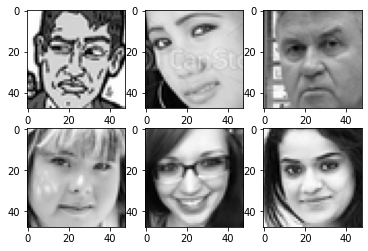

In [ ]:
# convert to an iterator and look at one random sample
dataiter = iter(test_loader)
sample_data = dataiter.next()
features, sample_labels = sample_data
print(features.shape)
print(sample_labels)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(features[i],cmap='gray')
plt.show()

In [ ]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral')

# Model Architecture

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels= 16,kernel_size= 3)
        self.conv1_bn = nn.BatchNorm2d(16)
        #46 by 46
        self.pool1 = nn.MaxPool2d(2, 2)
        #23 by 23
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels= 64,kernel_size= 3)
        #21 by 21
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        #10 by 10
        self.conv3 = nn.Conv2d(in_channels = 64,out_channels =  256, kernel_size =3)
        self.conv3_bn = nn.BatchNorm2d(256)
        #8 by 8
        self.conv4 = nn.Conv2d(in_channels = 256,out_channels =  512, kernel_size =3)
        self.conv4_bn = nn.BatchNorm2d(512)
        #6 by 6
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.drop3 = nn.Dropout(p = 0.4)
        self.fc3_bn = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128,7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))  
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
        x = (F.relu(self.conv3_bn(self.conv3(x))))
        x = (F.relu(self.conv4_bn(self.conv4(x))))  
        x = x.view(-1, 512 * 6 * 6)            
        x = F.relu((self.fc1_bn(self.drop1(self.fc1(x)))))              
        x = F.relu(self.fc2_bn(self.drop2(self.fc2(x))))            
        x = F.relu(self.fc3_bn(self.drop3(self.fc3(x))))
        x = self.fc4(x)                       
        return x

# Training Loop

In [ ]:
model = ConvNet().to(device)
model = model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images[:,None,:,:].type(torch.cuda.FloatTensor)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_correct = 0
        n_samples = 0
        if (i+1) % 100 == 0:
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            print(f'Accuracy of random batch: {acc} %')
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Accuracy of random batch: 42.1875 %
Epoch [1/50], Step [100/449], Loss: 1.4138
Accuracy of random batch: 40.625 %
Epoch [1/50], Step [200/449], Loss: 1.5579
Accuracy of random batch: 45.3125 %
Epoch [1/50], Step [300/449], Loss: 1.2857
Accuracy of random batch: 57.8125 %
Epoch [1/50], Step [400/449], Loss: 1.1814
Accuracy of random batch: 54.6875 %
Epoch [2/50], Step [100/449], Loss: 1.1785
Accuracy of random batch: 42.1875 %
Epoch [2/50], Step [200/449], Loss: 1.3377
Accuracy of random batch: 48.4375 %
Epoch [2/50], Step [300/449], Loss: 1.4201
Accuracy of random batch: 60.9375 %
Epoch [2/50], Step [400/449], Loss: 1.1198
Accuracy of random batch: 56.25 %
Epoch [3/50], Step [100/449], Loss: 1.0820
Accuracy of random batch: 48.4375 %
Epoch [3/50], Step [200/449], Loss: 1.1582
Accuracy of random batch: 50.0 %
Epoch [3/50], Step [300/449], Loss: 1.2012
Accuracy of random batch: 53.125 %
Epoch [3/50], Step [400/449], Loss: 1.4247
Accuracy of random batch: 65.625 %
Epoch [4/50], Step [100/

# Testing Loop

In [ ]:
with torch.no_grad():
    model = model.eval()
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in private_test_loader:
        images = images[:,None,:,:].type(torch.cuda.FloatTensor)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        if(acc!=0):
          print(f'Accuracy of {classes[i]}: {acc} %')
        else:
          print(f'Accuracy of ' + str(classes[i]) + ' is zero. WTFF!!' )

Accuracy of the network: 60.490387294511 %
Accuracy of Angry: 50.10183299389002 %
Accuracy of Disgust: 50.90909090909091 %
Accuracy of Fear: 39.96212121212121 %
Accuracy of Happy: 79.5221843003413 %
Accuracy of Sad: 56.397306397306394 %
Accuracy of Surprise: 69.47115384615384 %
Accuracy of Neutral: 57.98722044728434 %


# Feature Maps for First Convolutional Layer

Here we extract the weights of the first layer and perform convolution.

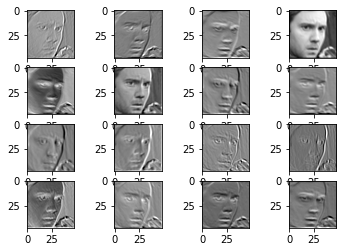

In [ ]:
img = train_dataset[0]
img = img[0].cpu().detach().numpy().astype(np.float32)
kernel = np.ones((5,5),np.float32)/25
weights = model.conv1.weight
weights = weights.cpu().detach().numpy()
for i in range(16):
  dst = cv2.filter2D(img,-1,weights[i][0],borderType=cv2.BORDER_CONSTANT)
  plt.subplot(4,4,i+1)
  plt.imshow(dst,cmap = 'gray')

**Few Experimented CNN's**

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels= 16,kernel_size= 3)
        self.conv1_bn = nn.BatchNorm2d(16)
        #46 by 46
        self.pool1 = nn.MaxPool2d(2, 2)
        #23 by 23
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels= 64,kernel_size= 3)
        #21 by 21
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        #10 by 10
        self.conv3 = nn.Conv2d(in_channels = 64,out_channels =  256, kernel_size =3)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels = 256,out_channels =  512, kernel_size =3)
        self.conv4_bn = nn.BatchNorm2d(512)
        #6 by 6
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.drop3 = nn.Dropout(p = 0.4)
        self.fc3_bn = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128,7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))  
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
        x = (F.relu(self.conv3_bn(self.conv3(x))))
        x = (F.relu(self.conv4_bn(self.conv4(x))))  
        x = x.view(-1, 512 * 6 * 6)            
        x = F.relu((self.fc1_bn(self.drop1(self.fc1(x)))))              
        x = F.relu(self.fc2_bn(self.drop2(self.fc2(x))))            
        x = F.relu(self.fc3_bn(self.drop3(self.fc3(x))))
        x = self.fc4(x)                       
        return x

In [ ]:
class ConvNet2layers(nn.Module):
    def __init__(self):
        super(ConvNet2layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels= 8,kernel_size= 5)
        # self.conv1_bn = nn.BatchNorm2d(8)
        #44 by 44
        # self.pool1 = nn.MaxPool2d(2, 2)
        #22 by 22
        self.conv2 = nn.Conv2d(in_channels = 8,out_channels= 32,kernel_size= 5)
        #18 by 18
        # self.conv2_bn = nn.BatchNorm2d(32)
        # self.pool2 = nn.MaxPool2d(2,2)
        #9 by 9
        self.fc1 = nn.Linear(32 * 40* 40, 128)
        self.drop1 = nn.Dropout(p=0.2)
        # self.fc1_bn = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(128, 7)
        # self.drop2 = nn.Dropout(p=0.2)
        # self.fc2_bn = nn.BatchNorm1d(512)
        # self.fc3 = nn.Linear(512, 128)
        # self.drop3 = nn.Dropout(p = 0.4)
        # self.fc3_bn = nn.BatchNorm1d(128)
        # self.fc4 = nn.Linear(128,7)

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x))
        # x = (F.relu(self.conv3_bn(self.conv3(x))))
        # x = (F.relu(self.conv4_bn(self.conv4(x))))  
        x = x.view(-1, 32 * 40 * 40)            
        x = F.relu(self.drop1(self.fc1(x)))              
        # x = F.relu(self.fc2_bn(self.drop2(self.fc2(x))))            
        # x = F.relu(self.fc3_bn(self.drop3(self.fc3(x))))
        x = self.fc2(x)                      
        return x

In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels= 16,kernel_size= 1)
        self.conv1_bn = nn.BatchNorm2d(16)
        #48 by 48
        self.pool1 = nn.MaxPool2d(2, 2)
        #24 by 24
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels= 64,kernel_size= 1)
        #24 by 24
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        #12 by 12
        self.conv3 = nn.Conv2d(in_channels = 64,out_channels =  256, kernel_size =1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels = 256,out_channels =  512, kernel_size =1)
        self.conv4_bn = nn.BatchNorm2d(512)
        #12 by 12
        self.fc1 = nn.Linear(512 * 12 * 12, 1024)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.drop3 = nn.Dropout(p = 0.4)
        self.fc3_bn = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128,7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))  
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
        x = (F.relu(self.conv3_bn(self.conv3(x))))
        x = (F.relu(self.conv4_bn(self.conv4(x))))  
        x = x.view(-1, 512 * 12 * 12)            
        x = F.relu((self.fc1_bn(self.drop1(self.fc1(x)))))              
        x = F.relu(self.fc2_bn(self.drop2(self.fc2(x))))            
        x = F.relu(self.fc3_bn(self.drop3(self.fc3(x))))
        x = self.fc4(x)                       
        return x